# Hands-on activity Description:
In this hands-on activity, we will first build a binary text classification model to classify whether a forum post in a MOOC (Massive Open Online Course) is a question or not, using only the raw text content.

Next, we will explore an ordinal regression model to analyze the level of confusion expressed in each post, rated on a scale from 1 to 7.

These tasks illustrate how learning analytics and natural language processing (NLP) techniques can be applied to understand learner behavior and enhance scalable online education.

You will then have the opportunity to apply these methods to additional outcome variables, such as opinion and urgency, during the session.

## Learning Objective
By completing this activity, you will:

1. Understand the fundamentals of text classification using machine learning.

2. Learn how to preprocess raw text into structured features (feature engineering)

3. Explore two modeling approaches through guided demos:

    a) Binary classification to examine whether a forum post is a question.

    b) Ordinal regression to examine a forum post's confusion level (on a 1–7 scale).

4. Apply what you've learned by building models to examine two additional outcome variables (e.g., opinion, urgency)

## Data
You are provided with a dataset of discussion forum posts from a Massive Open Online Course (MOOC). Each entry in the dataset contains:

Text - raw text of the forum post.

Question — a binary indicator, where 1 means the post contains a question.

Opinion — a binary indicator (0 or 1), where 1 means the post expresses a personal opinion.

Confusion — a Likert-scale rating from 1 to 7 indicating how much confusion is expressed.

Urgency —  a Likert-scale rating from 1 to 7 indicating the urgency or immediacy conveyed in the post.

Please find the data here https://drive.google.com/file/d/1ks1yMBQ85Kj9m9GtdLNR8ygQ_aUgFF-i/view?usp=drive_link

## Install Necessary Libraries and Data Loading

In [1]:
pip install -q pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data = pd.read_csv("mooc_data.csv")


In [4]:
data

,Text,Question,Opinion,Confusion,Urgency
0,Interesting! How often we say those things to ...,0,1,2.0,1.5
1,"What is \Algebra as a Math Game\"" or are you j...",1,0,5.0,3.5
2,I like the idea of my kids principal who says ...,0,1,3.0,2.5
3,"From their responses, it seems the students re...",0,1,3.0,2.5
4,"The boys loved math, because \there is freedom...",0,1,2.0,3.0
...,...,...,...,...,...
29599,The p value tells us the probability of observ...,0,0,3.5,2.0
29600,given the null hypothesis is considered true,0,0,3.5,1.0
29601,"> Hello Josh,_x0007__x0007_Is this hypothesis ...",1,0,5.0,5.5
29602,"Hi Josh,_x0007__x0007__x0007__x0007_Looking at...",1,0,5.0,5.5


## Training-Validation Split
We split the data into separate training and validation sets. The validation set is used to evaluate model performance after training. We set random_state=42 to ensure consistent splits across runs.

In [5]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=0.2, random_state=42)

## Basic Feature Engineering

We would like to take the raw text of a MOOC forum post and classify outcomes such as whether the post is a question (binary classification) or how much confusion it expresses (ordinal regression). However, machine learning models like logistic regression and ridge regression require numeric inputs—not raw text.

Therefore, we use feature engineering to transform raw text into a structured feature matrix. Feature engineering is the process of transforming raw data into numerical representations (“features”) that machine learning models can use. For text, this means converting sentences or documents (which are unstructured) into vectors (structured, numeric). In this activity, each row of the matrix represents a forum post, and each column corresponds to a numeric feature derived from the text—for example, the presence of specific words.

In [6]:
import re
# --- Function to compute word presence matrix ---
def words_in_texts(words, texts):
    """
    Generate a binary indicator matrix showing whether each word appears in each text.

    Parameters:
    - words: list of strings (tokens, symbols, or words)
    - texts: pandas Series of text entries

    Returns:
    - indicator_array: (n_texts x n_words) NumPy array of 0/1 values
    """
    texts = texts.str.lower().fillna('')
    indicator_array = np.zeros((len(texts), len(words)), dtype=int)

    for i, word in enumerate(words):
        escaped_word = re.escape(word)
        if word.isalnum():
            pattern = rf'\b{escaped_word}\b'
        else:
            pattern = escaped_word
        indicator_array[:, i] = texts.str.contains(pattern, regex=True).astype(int)

    return indicator_array

In [7]:
words_in_texts(['hello', '！', 'world'],
                   pd.Series(['hello', 'hello world', 'hello world！']))

array([[1, 0, 0],
       [1, 0, 1],
       [1, 1, 1]])

### DEMO 1 Predicting Whether the Post is a Question

#### EDA
We aim to identify features that distinguish question posts from non-question posts. For binary features, we can compare the proportion of question posts containing the word to the proportion in non-question posts. Larger differences suggest more informative features for classification task.

In [8]:
target_words = ['what', 'how', 'explain', 'why','do', 'does', 'did', '?']

In [9]:
word_presence = words_in_texts(target_words, data['Text'])
word_df = pd.DataFrame(word_presence, columns=target_words)
word_df['Label'] = data['Question']
word_df.head()

,what,how,explain,why,do,does,did,?,Label
0,1,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0


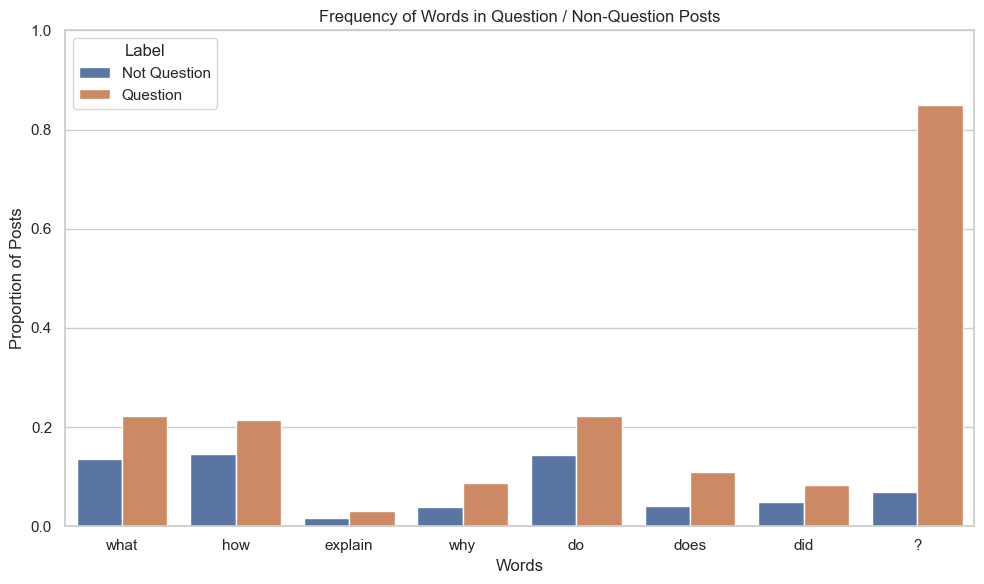

In [10]:
# --- Calculate class-conditional proportions ---
word_stats = []
for word in target_words:
    for label in [0, 1]:
        prop = word_df[word][word_df['Label'] == label].mean()
        word_stats.append({'Word': word, 'Label': 'Question' if label == 1 else 'Not Question', 'Proportion': prop})

plot_df = pd.DataFrame(word_stats)

# --- Plot ---
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="Word", y="Proportion", hue="Label")
plt.title("Frequency of Words in Question / Non-Question Posts")
plt.ylabel("Proportion of Posts")
plt.xlabel("Words")
plt.ylim(0, 1)
plt.legend(title="Label")
plt.tight_layout()
plt.show()

#### Basic Classification
Notice that the output of function `words_in_texts()` is a numeric matrix containing features for each post. This means we can use it directly to train a classifier! We used logistic regression in the demo for simplicity, feel free to try different models (e.g. random forest, Naive Bayes, Support Vector Machine (SVM), MLP) in your work!

In [11]:
X_train = words_in_texts(target_words, train['Text'])
Y_train = train['Question'].values
X_val = words_in_texts(target_words, val['Text'])
Y_val = val['Question'].values


In [12]:
len(X_train), X_train[:10]

(23683,
 array([[1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0]]))

In [13]:
len(Y_train), Y_train[:10]

(23683, array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0]))

In [14]:
from sklearn.linear_model import LogisticRegression

# Train model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Check training accuracy
training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

# Check validation accuracy
val_accuracy = model.score(X_val, Y_val)
print("Validation Accuracy: ", val_accuracy)




Training Accuracy:  0.9156779124266351
Validation Accuracy:  0.9153859145414626


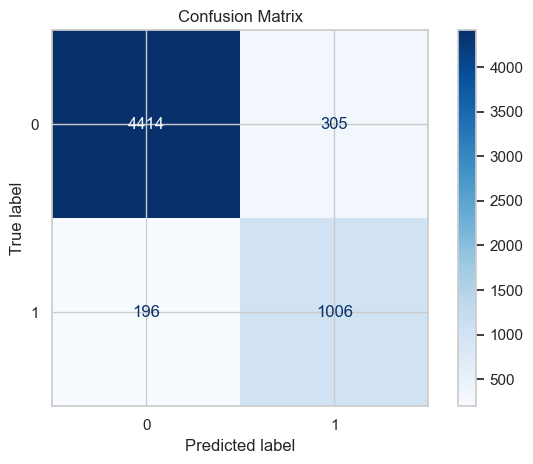

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Predict class labels
y_pred = model.predict(X_val)

# Compute and plot confusion matrix
cm = confusion_matrix(Y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#### Evaluating Classifiers

Accuracy measures overall correctness.

Precision indicates how many predicted positives are actually correct.

Recall shows how many actual positives were correctly identified.

F1 Score balances precision and recall into a single metric.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y_val, y_pred)
precision = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1 = f1_score(Y_val, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")


Accuracy:  0.915
Precision: 0.767
Recall:    0.837
F1 Score:  0.801


##### ROC-AUC Curve

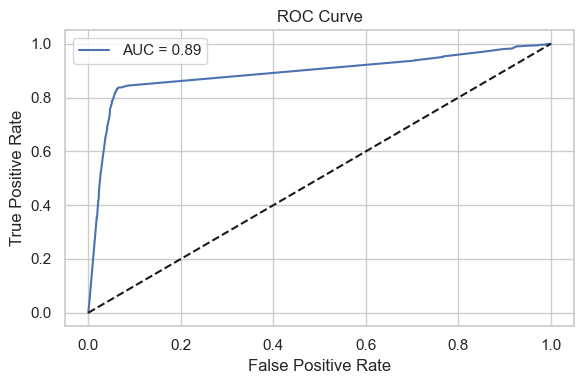

In [17]:
# Predict probability scores
y_prob = model.predict_proba(X_val)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_val, y_prob)
auc_score = roc_auc_score(Y_val, y_prob)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


#### TF-IDF

Previously, we manually selected features—such as specific keywords or punctuation marks—to indicate whether a forum post was a question. While this approach is simple and interpretable, it relies on prior assumptions and may miss other informative patterns in the text.

In contrast, TF-IDF (Term Frequency–Inverse Document Frequency) automatically extracts features from the entire vocabulary. It gives higher weight to words that appear frequently in a specific post but are rare across the dataset, helping the model focus on words that are more distinctive and meaningful.

Unlike manual feature selection, TF-IDF provides a richer, data-driven representation of the text

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Ensure that all text entries are strings
train['Text'] = train['Text'].astype(str)
val['Text'] = val['Text'].astype(str)

# Fit the vectorizer on training text and transform both training and validation sets
X_train_tfidf = vectorizer.fit_transform(train['Text'].fillna(''))
X_val_tfidf = vectorizer.transform(val['Text'].fillna(''))

# Extract target labels for binary classification (1 = question, 0 = not a question)
Y_train = train['Question'].values
Y_val = val['Question'].values

# Initialize and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, Y_train)

# Predict labels on both training and validation sets
y_train_pred = model.predict(X_train_tfidf)
y_val_pred = model.predict(X_val_tfidf)

# Print accuracy scores for training and validation sets
print("Training Accuracy:", accuracy_score(Y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(Y_val, y_val_pred))


Training Accuracy: 0.9078664020605498
Validation Accuracy: 0.8875190001688904


In [19]:
X_train_tfidf


<23683x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1216656 stored elements in Compressed Sparse Row format>

In [20]:
X_train_tfidf.shape

(23683, 5000)

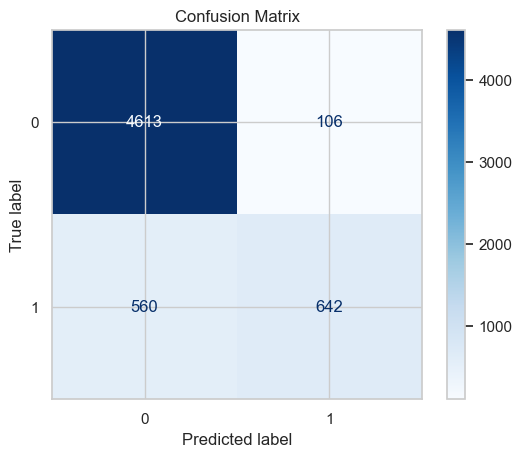

Accuracy:  0.888
Precision: 0.858
Recall:    0.534
F1 Score:  0.658
Validation AUC: 0.9224671990138635


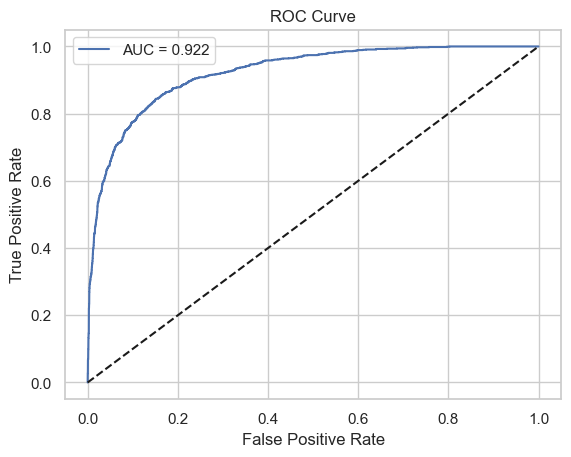

In [21]:
# Confusion Matrix
cm = confusion_matrix(Y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(Y_val, y_val_pred)
precision = precision_score(Y_val, y_val_pred)
recall = recall_score(Y_val, y_val_pred)
f1 = f1_score(Y_val, y_val_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

# ROC-AUC curve
y_val_proba = model.predict_proba(X_val_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_val, y_val_proba)
auc_score = roc_auc_score(Y_val, y_val_proba)
print("Validation AUC:", auc_score)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### DEMO 2 Predicting the Confusion Level of the Post


#### Basic Classification

In [22]:
target_words = ['what', 'how', 'explain', '?','confused','why']

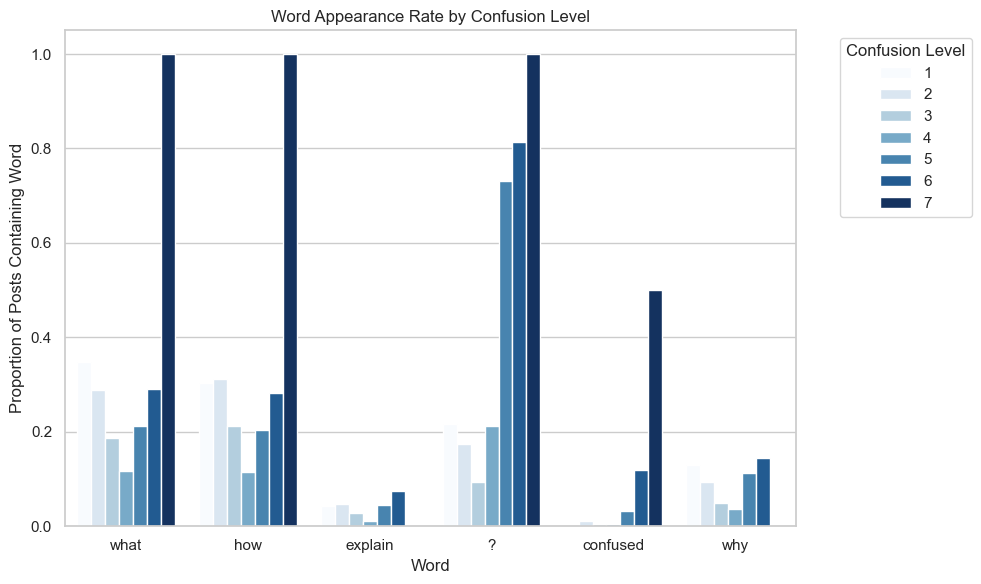

In [23]:
word_matrix = words_in_texts(target_words, data['Text'])
word_df = pd.DataFrame(word_matrix, columns=target_words)
word_df['Confusion'] = data['Confusion'].astype(int)

plot_data = []
for word in target_words:
    for level in sorted(word_df['Confusion'].unique()):
        subset = word_df[word_df['Confusion'] == level]
        proportion = subset[word].mean()
        plot_data.append({
            'Word': word,
            'Confusion Level': level,
            'Proportion': proportion
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='Word', y='Proportion', hue='Confusion Level', palette='Blues')
plt.title("Word Appearance Rate by Confusion Level")
plt.ylabel("Proportion of Posts Containing Word")
plt.xlabel("Word")
plt.legend(title="Confusion Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Model: Ridge is a linear regression model with L2 regularization. It’s ideal when we want to predict values like 1–7 as numbers rather than categories.

Evaluation: MAE: Measures how far prediction is from true rating, keeping ordinal distance

In [24]:
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error
# Generate feature matrices for train and validation
X_train = words_in_texts(target_words, train['Text'])
X_val = words_in_texts(target_words, val['Text'])

# Extract ordinal labels
y_train_ord = train['Confusion'].astype(int).values
y_val_ord = val['Confusion'].astype(int).values

#  Train Ridge regression on these features
model_ord = Ridge()
model_ord.fit(X_train, y_train_ord)

# Predict and evaluate
y_pred_cont = model_ord.predict(X_val)
mae = mean_absolute_error(y_val_ord, y_pred_cont)
print("[Ordinal] Confusion MAE:", mae)

# Round and clip to [1, 7]
y_pred_round = np.clip(np.round(y_pred_cont), 1, 7).astype(int)
ord_acc = accuracy_score(y_val_ord, y_pred_round)
print("[Ordinal] Confusion Accuracy:", ord_acc)

[Ordinal] Confusion MAE: 0.52740989746326
[Ordinal] Confusion Accuracy: 0.5894274615774362


In [25]:
y_pred_round

array([4, 4, 4, ..., 4, 4, 4])

#### TF-IDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_text_train = train['Text'].fillna('')
X_text_val = val['Text'].fillna('')

# 2. Initialize and fit TF-IDF vectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    max_features=5000,
    ngram_range=(1, 2)
)

# 3. Fit on training data and transform both train and val sets
X_train_tfidf = tfidf.fit_transform(X_text_train)
X_val_tfidf = tfidf.transform(X_text_val)


In [27]:
# Train Ridge regression on TF-IDF features
model_ord = Ridge()
model_ord.fit(X_train_tfidf, y_train_ord)

# Predict continuous values on validation set
y_pred_cont = model_ord.predict(X_val_tfidf)

# Compute MAE
mae = mean_absolute_error(y_val_ord, y_pred_cont)
print("[Ordinal][TF-IDF] MAE:", mae)

# Round predictions and clip to valid range [1, 7]
y_pred_round = np.clip(np.round(y_pred_cont), 1, 7).astype(int)

# Compute classification accuracy
ord_acc = accuracy_score(y_val_ord, y_pred_round)
print("[Ordinal][TF-IDF] Accuracy:", ord_acc)

[Ordinal][TF-IDF] MAE: 0.42219283071694613
[Ordinal][TF-IDF] Accuracy: 0.670325958452964


## Conclusion
This hands-on activity focused on building classification models entirely based on raw text data from MOOC forum posts. We walked through a complete data analytics workflow—from data preprocessing and feature extraction to model training, evaluation, and visualization. This end-to-end process demonstrated how even simple models can effectively capture meaningful signals in educational text data.

This work can be extended to more advanced techniques. For example, multi-label classification can be used to simultaneously predict whether a forum post expresses confusion, urgency, and opinion. Additionally, more sophisticated feature engineering methods—such as word embedding will have the potential to capture the meaning of the texts and increase model performance.

Bag of Words and TF-IDF are traditional methods for representing text, where Bag of Words counts each word’s occurrences and TF-IDF further weighs words by how unique they are across documents. Both are simple but ignore word order and meaning. In contrast, word embeddings like GloVe or BERT turn words or entire texts into dense vectors that capture semantic meaning and similarity, allowing models to better understand language context.

## Example: GloVe
 It looks at how often words appear together in large collections of text and gives each word a vector—a list of numbers—that captures its meaning and how it relates to other words. Similar words will have similar vectors. You can use these vectors as features in machine learning models for tasks like text classification. More information can be found in https://nlp.stanford.edu/projects/glove/


In [28]:
# !pip install gensim

In [29]:
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-100")

/Users/zhenpeng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [30]:
glove

In [31]:
'how' in glove

True

In [32]:
glove['how'].shape

(100,)

Validation Accuracy: 0.7930646250844404


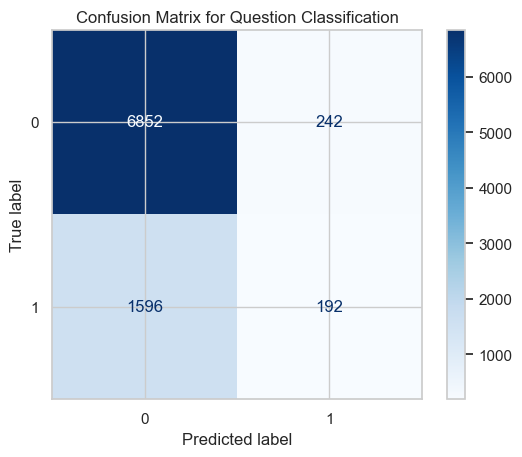

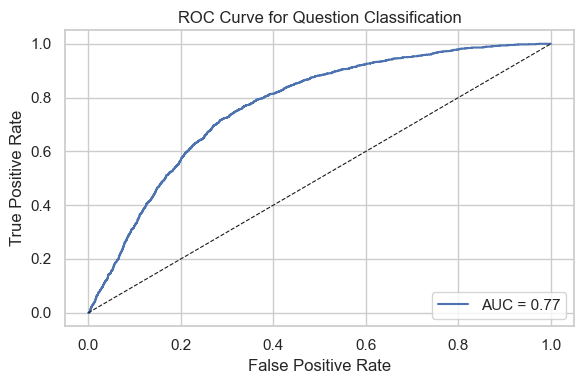

In [33]:

# 1. Prepare data: ensure Text column has no NaNs
data['Text'] = data['Text'].fillna("")

# 2. Define sentence_to_vec (using pre-loaded `glove` model)
def sentence_to_vec(sentence):
    if not isinstance(sentence, str):
        sentence = ""
    words = sentence.lower().split()
    word_vecs = [glove[word] for word in words if word in glove]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(glove.vector_size)

# 3. Build feature matrix X and label vector y
X_all = np.vstack([sentence_to_vec(text) for text in data['Text']])
y_all = data['Question'].astype(int).values

# 4. Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)

# 5. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6. Predict on validation set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]  # probability for positive class

# 7. Compute and print metrics
acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", acc)

# 8. Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Question Classification")
plt.show()

# 9. ROC AUC curve
auc = roc_auc_score(y_val, y_prob)
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Question Classification")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [34]:
X_all, X_all.shape

(array([[-0.10639115,  0.42555529,  0.32945848, ..., -0.53078181,
          0.43710828,  0.46329364],
        [-0.20143333,  0.42218345,  0.46639469, ..., -0.51942593,
          0.53421098,  0.37857148],
        [ 0.04311122,  0.15355872,  0.35650367, ..., -0.30333307,
          0.53013068,  0.3264195 ],
        ...,
        [-0.22115786,  0.44388837,  0.19457099, ..., -0.49613467,
          0.40597025,  0.03243426],
        [-0.21136238,  0.3301408 ,  0.60414755, ..., -0.33624569,
          0.46654209,  0.3049804 ],
        [ 0.11356   ,  0.41688001,  0.55366999, ..., -0.047034  ,
         -0.08201   , -0.35398999]]),
 (29604, 100))

## Note
Parts of the data for this activity were adapted from the Classifying MOOC Discussion Forums project from Stanford University https://github.com/akshayka/edxclassify?tab=readme-ov-file. Parts of this activity were inspired from the DATA100 Spam/Ham Classification project from UC Berkeley https://ds100.org.

## Now it's your turn!
In addition to Question and Confusion, the dataset includes two more outcome variables: Opinion (binary) and Urgency (ordinal, 1–7). Using the examples provided, build a binary classification model for Opinion and an ordinal regression model for Urgency. Focus on identifying meaningful handcrafted features (e.g., specific keywords), and evaluate your models!

Here are three questions that you may want to answer when doing the task.
1. How did you identify features for your model?
2. What did you try that worked—or didn’t work—and why?
3. How does your bag-of-words method compare to more advanced techniques like TF-IDF or GloVe?

### Demo 3 Predicting Whether the Post is an Opinion

In [35]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=0.2, random_state=42)


## Run LogisticRegression + bag-of-words

### design the target_words

In [36]:
# target_words = ['I', 'think', 'believe', 'suggest', 'consider', '!', 'in my opinion', 'my', 'suggestion', 'opinion', 'feel', 'personally']

# Accuracy:  0.591
# Precision: 0.684
# Recall:    0.467
# F1 Score:  0.555

In [37]:
# target_words = ['I', 'think', 'believe', 'suggest', 'consider', 'in my opinion', 'my', 'suggestion', 'opinion', 'feel', 'personally']

# Accuracy:  0.591
# Precision: 0.684
# Recall:    0.467
# F1 Score:  0.555


In [38]:
# target_words = ['think', 'believe', 'suggest', 'consider', 'in my opinion', 'my', 'opinion', 'feel', 'personally']

# Accuracy:  0.591
# Precision: 0.685
# Recall:    0.465
# F1 Score:  0.554

In [39]:
# target_words = ['think', 'believe', 'my', 'feel']

# Accuracy:  0.590
# Precision: 0.689
# Recall:    0.455
# F1 Score:  0.548

### Convert text to numerical form

In [40]:

word_presence = words_in_texts(target_words, data['Text'])
word_df = pd.DataFrame(word_presence, columns=target_words)
word_df['Label'] = data['Opinion']
word_df.head()

,what,how,explain,?,confused,why,Label
0,1,1,0,0,0,0,1
1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,1,0,0,0,1
4,1,0,0,0,0,0,1


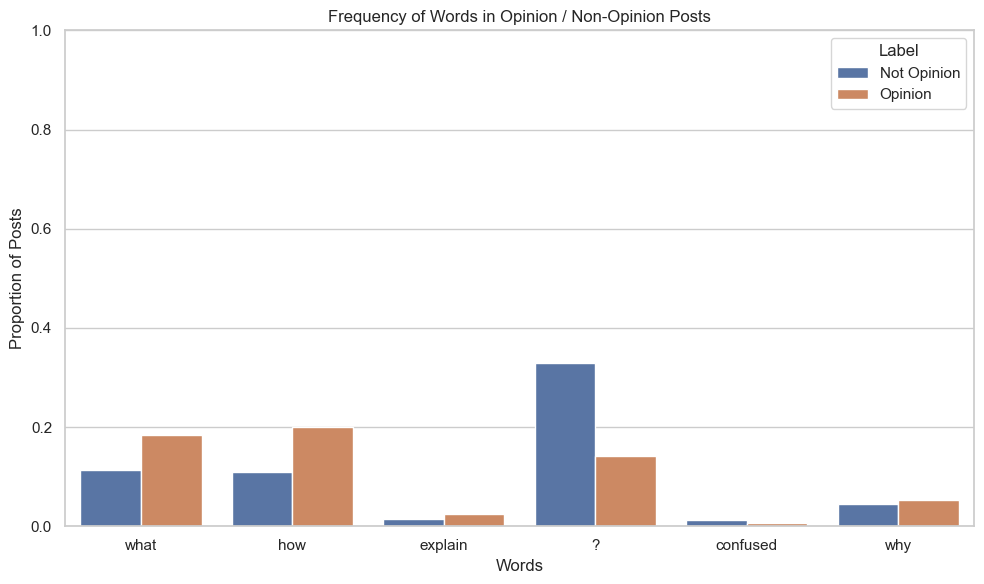

In [41]:
# --- Calculate class-conditional proportions ---
word_stats = []
for word in target_words:
    for label in [0, 1]:
        prop = word_df[word][word_df['Label'] == label].mean()
        word_stats.append({'Word': word, 'Label': 'Opinion' if label == 1 else 'Not Opinion', 'Proportion': prop})

plot_df = pd.DataFrame(word_stats)

# --- Plot ---
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="Word", y="Proportion", hue="Label")
plt.title("Frequency of Words in Opinion / Non-Opinion Posts")
plt.ylabel("Proportion of Posts")
plt.xlabel("Words")
plt.ylim(0, 1)
plt.legend(title="Label")
plt.tight_layout()
plt.show()

### get datasets

In [42]:
X_train = words_in_texts(target_words, train['Text'])
Y_train = train['Opinion'].values
X_val = words_in_texts(target_words, val['Text'])
Y_val = val['Opinion'].values


#####    Demo 3 Predicting Whether the Post is a Opinion   #####
##### the results of LogisticRegression + bag-of-words #####
Training Accuracy:  0.6320989739475573
Validation Accuracy:  0.6149299104880932


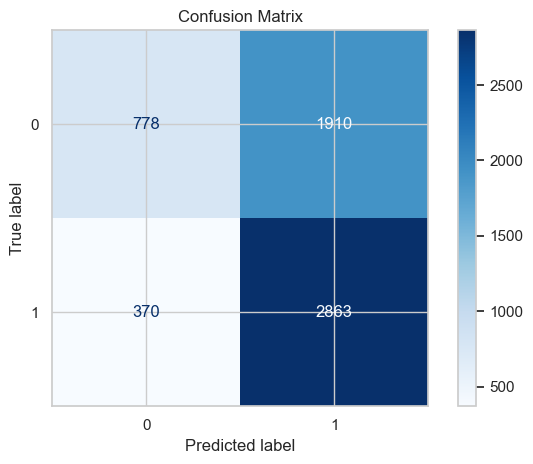

Accuracy:  0.615
Precision: 0.600
Recall:    0.886
F1 Score:  0.715


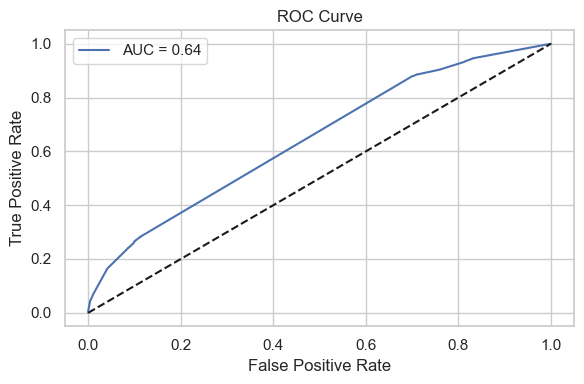

#####    Demo 3 Predicting Whether the Post is a Opinion   #####
##### the results of LogisticRegression + bag-of-words #####


In [43]:
print('#####    Demo 3 Predicting Whether the Post is a Opinion   #####')
print('##### the results of LogisticRegression + bag-of-words #####')

from sklearn.linear_model import LogisticRegression

# Train model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Check training accuracy
training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

# Check validation accuracy
val_accuracy = model.score(X_val, Y_val)
print("Validation Accuracy: ", val_accuracy)



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Predict class labels
y_pred = model.predict(X_val)

# Compute and plot confusion matrix
cm = confusion_matrix(Y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y_val, y_pred)
precision = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1 = f1_score(Y_val, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

# Predict probability scores
y_prob = model.predict_proba(X_val)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_val, y_prob)
auc_score = roc_auc_score(Y_val, y_prob)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

print('#####    Demo 3 Predicting Whether the Post is a Opinion   #####')
print('##### the results of LogisticRegression + bag-of-words #####')

## Run LogisticRegression + TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Ensure that all text entries are strings
train['Text'] = train['Text'].astype(str)
val['Text'] = val['Text'].astype(str)

# Fit the vectorizer on training text and transform both training and validation sets
X_train_tfidf = vectorizer.fit_transform(train['Text'].fillna(''))
X_val_tfidf = vectorizer.transform(val['Text'].fillna(''))

# Extract target labels for binary classification (1 = question, 0 = not a question)
Y_train = train['Opinion'].values
Y_val = val['Opinion'].values

# Initialize and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, Y_train)

# Predict labels on both training and validation sets
y_train_pred = model.predict(X_train_tfidf)
y_val_pred = model.predict(X_val_tfidf)



#####    Demo 3 Predicting Whether the Post is a Opinion   #####
##### the results of LogisticRegression + TF-IDF #####
Training Accuracy: 0.8442342608622219
Validation Accuracy: 0.7941226144232393


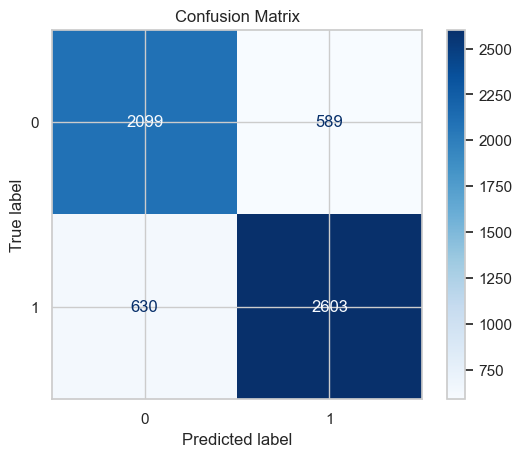

Accuracy:  0.794
Precision: 0.815
Recall:    0.805
F1 Score:  0.810
Validation AUC: 0.8769960176306837


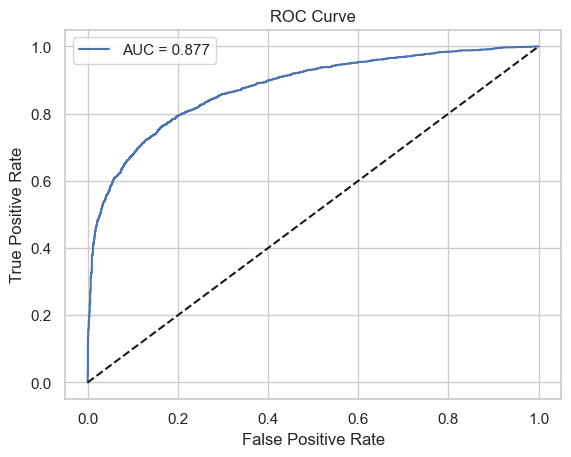

#####    Demo 3 Predicting Whether the Post is a Opinion   #####
##### the results of LogisticRegression + TF-IDF #####


In [45]:
print('#####    Demo 3 Predicting Whether the Post is a Opinion   #####')
print('##### the results of LogisticRegression + TF-IDF #####')

# Print accuracy scores for training and validation sets
print("Training Accuracy:", accuracy_score(Y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(Y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(Y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(Y_val, y_val_pred)
precision = precision_score(Y_val, y_val_pred)
recall = recall_score(Y_val, y_val_pred)
f1 = f1_score(Y_val, y_val_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

# ROC-AUC curve
y_val_proba = model.predict_proba(X_val_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_val, y_val_proba)
auc_score = roc_auc_score(Y_val, y_val_proba)
print("Validation AUC:", auc_score)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print('#####    Demo 3 Predicting Whether the Post is a Opinion   #####')
print('##### the results of LogisticRegression + TF-IDF #####')

## Run LogisticRegression + GloVe

In [46]:
# import gensim.downloader as api
# glove = api.load("glove-wiki-gigaword-100")



# 1. Prepare data: ensure Text column has no NaNs
data['Text'] = data['Text'].fillna("")

# 2. Define sentence_to_vec (using pre-loaded `glove` model)
def sentence_to_vec(sentence):
    if not isinstance(sentence, str):
        sentence = ""
    words = sentence.lower().split()
    word_vecs = [glove[word] for word in words if word in glove]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(glove.vector_size)

# 3. Build feature matrix X and label vector y
X_all = np.vstack([sentence_to_vec(text) for text in data['Text']])
y_all = data['Opinion'].astype(int).values

# 4. Keep the same train/validation sets as above
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# 5. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

# 6. Predict labels on both training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)


#####    Demo 3 Predicting Whether the Post is a Opinion   #####
##### the results of LogisticRegression + GloVe #####
Training Accuracy: 0.7436980112316852
Validation Accuracy: 0.7475088667454822


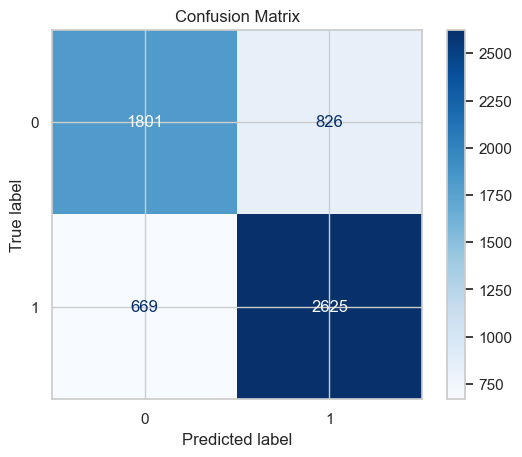

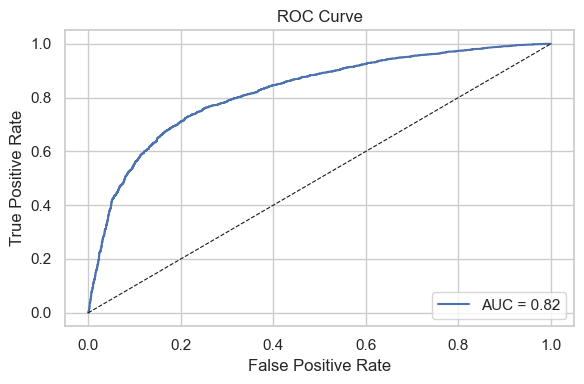

#####    Demo 3 Predicting Whether the Post is a Opinion   #####
##### the results of LogisticRegression + GloVe #####


In [47]:
print('#####    Demo 3 Predicting Whether the Post is a Opinion   #####')
print('##### the results of LogisticRegression + GloVe #####')

# 7. Compute and print metrics
print("Training Accuracy:", accuracy_score(Y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(Y_val, y_val_pred))

# 8. Confusion matrix
cm = confusion_matrix(Y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# 9. ROC AUC curve
y_prob = model.predict_proba(X_val)[:, 1]  # probability for positive class
auc = roc_auc_score(Y_val, y_prob)
fpr, tpr, thresholds = roc_curve(Y_val, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print('#####    Demo 3 Predicting Whether the Post is a Opinion   #####')
print('##### the results of LogisticRegression + GloVe #####')

### Demo 4 Predicting the Urgency Level of the Post

## Run Ridge + bag-of-words

In [48]:
# target_words = ['quick', 'immediate', 'urgent', 'emergency', 'soon', 'as soon as', 'asap', 'important', 'help']

# [Ordinal] Urgency MAE: 1.1450110880033395
# [Ordinal] Urgency Accuracy: 0.35281202499577774

In [49]:
# target_words = ['quick', 'immediate', 'soon', 'as soon as', 'important', 'help']

# [Ordinal] Urgency MAE: 1.1452334883783608
# [Ordinal] Urgency Accuracy: 0.35264313460564095

In [50]:
target_words = ['urgent', 'emergency', 'asap', 'important', 'help']

# [Ordinal] Urgency MAE: 1.1449594822453306
# [Ordinal] Urgency Accuracy: 0.3548387096774194

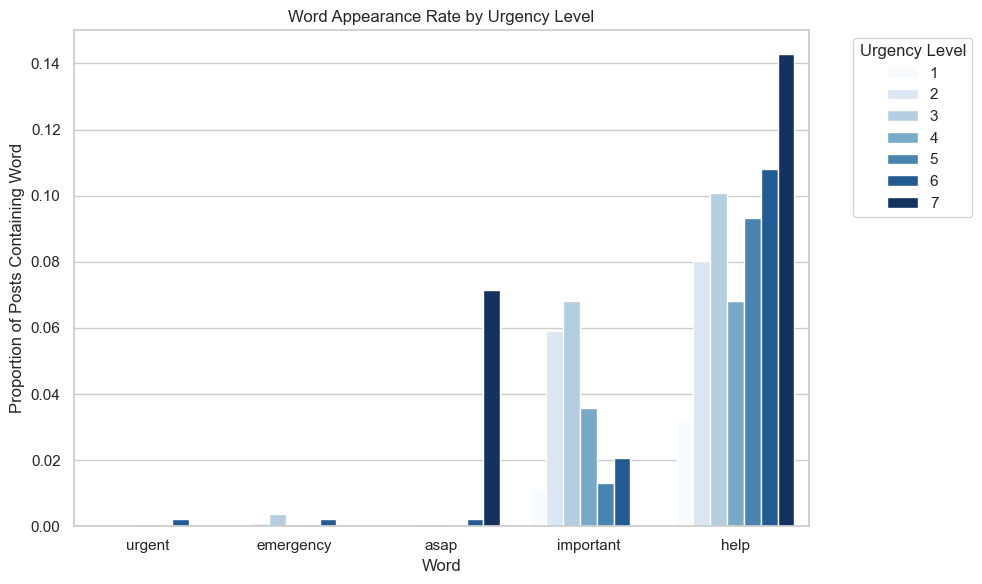

In [51]:
word_matrix = words_in_texts(target_words, data['Text'])
word_df = pd.DataFrame(word_matrix, columns=target_words)
word_df['Urgency'] = data['Urgency'].astype(int)

plot_data = []
for word in target_words:
    for level in sorted(word_df['Urgency'].unique()):
        subset = word_df[word_df['Urgency'] == level]
        proportion = subset[word].mean()
        plot_data.append({
            'Word': word,
            'Urgency Level': level,
            'Proportion': proportion
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='Word', y='Proportion', hue='Urgency Level', palette='Blues')
plt.title("Word Appearance Rate by Urgency Level")
plt.ylabel("Proportion of Posts Containing Word")
plt.xlabel("Word")
plt.legend(title="Urgency Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [52]:
print('#####    Demo 4 Predicting the Urgency Level of the Post   #####')
print('##### the results of Ridge + bag-of-words #####')


from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error
# Generate feature matrices for train and validation
X_train = words_in_texts(target_words, train['Text'])
X_val = words_in_texts(target_words, val['Text'])

# Extract ordinal labels
y_train_ord = train['Urgency'].astype(int).values
y_val_ord = val['Urgency'].astype(int).values

#  Train Ridge regression on these features
model_ord = Ridge()
model_ord.fit(X_train, y_train_ord)

# Predict and evaluate
y_pred_cont = model_ord.predict(X_val)
mae = mean_absolute_error(y_val_ord, y_pred_cont)
print("[Ordinal] Urgency MAE:", mae)

# Round and clip to [1, 7]
y_pred_round = np.clip(np.round(y_pred_cont), 1, 7).astype(int)
ord_acc = accuracy_score(y_val_ord, y_pred_round)
print("[Ordinal] Urgency Accuracy:", ord_acc)

print('#####    Demo 4 Predicting the Urgency Level of the Post   #####')
print('##### the results of Ridge + bag-of-words #####')

#####    Demo 4 Predicting the Urgency Level of the Post   #####
##### the results of Ridge + bag-of-words #####
[Ordinal] Urgency MAE: 1.1449594822453306
[Ordinal] Urgency Accuracy: 0.3548387096774194
#####    Demo 4 Predicting the Urgency Level of the Post   #####
##### the results of Ridge + bag-of-words #####


## Run Ridge + TF-IDF

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_text_train = train['Text'].fillna('')
X_text_val = val['Text'].fillna('')

# 2. Initialize and fit TF-IDF vectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    max_features=5000,
    ngram_range=(1, 2)
)

# 3. Fit on training data and transform both train and val sets
X_train_tfidf = tfidf.fit_transform(X_text_train)
X_val_tfidf = tfidf.transform(X_text_val)


In [54]:

# Train Ridge regression on TF-IDF features
model_ord = Ridge()
model_ord.fit(X_train_tfidf, y_train_ord)

# Predict continuous values on validation set
y_pred_cont = model_ord.predict(X_val_tfidf)



print('#####    Demo 4 Predicting the Urgency Level of the Post   #####')
print('##### the results of Ridge + TF-IDF #####')

# Compute MAE
mae = mean_absolute_error(y_val_ord, y_pred_cont)
print("[Ordinal] Urgency MAE:", mae)

# Round predictions and clip to valid range [1, 7]
y_pred_round = np.clip(np.round(y_pred_cont), 1, 7).astype(int)

# Compute classification accuracy
ord_acc = accuracy_score(y_val_ord, y_pred_round)
print("[Ordinal] Urgency Accuracy:", ord_acc)

print('#####    Demo 4 Predicting the Urgency Level of the Post   #####')
print('##### the results of Ridge + TF-IDF #####')

#####    Demo 4 Predicting the Urgency Level of the Post   #####
##### the results of Ridge + TF-IDF #####
[Ordinal] Urgency MAE: 0.7934620706654001
[Ordinal] Urgency Accuracy: 0.41462590778584696
#####    Demo 4 Predicting the Urgency Level of the Post   #####
##### the results of Ridge + TF-IDF #####


## Run Ridge + GloVe

In [55]:
# import gensim.downloader as api
# glove = api.load("glove-wiki-gigaword-100")



# 1. Prepare data: ensure Text column has no NaNs
data['Text'] = data['Text'].fillna("")

# 2. Define sentence_to_vec (using pre-loaded `glove` model)
def sentence_to_vec(sentence):
    if not isinstance(sentence, str):
        sentence = ""
    words = sentence.lower().split()
    word_vecs = [glove[word] for word in words if word in glove]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(glove.vector_size)

# 3. Build feature matrix X and label vector y
X_all = np.vstack([sentence_to_vec(text) for text in data['Text']])
y_all = data['Urgency'].astype(int).values

# 4. Keep the same train/validation sets as above
from sklearn.model_selection import train_test_split
X_train_glove, X_val_glove, y_train_ord, y_val_ord = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# 5. Train Ridge regression on GloVe features
model_ord = Ridge()
model_ord.fit(X_train_glove, y_train_ord)


# 6. # Predict continuous values on validation set
y_pred_cont = model_ord.predict(X_val_glove)



In [56]:

print('#####    Demo 4 Predicting the Urgency Level of the Post   #####')
print('##### the results of Ridge + GloVe #####')

# Compute MAE
mae = mean_absolute_error(y_val_ord, y_pred_cont)
print("[Ordinal] Urgency MAE:", mae)

# Round predictions and clip to valid range [1, 7]
y_pred_round = np.clip(np.round(y_pred_cont), 1, 7).astype(int)

# Compute classification accuracy
ord_acc = accuracy_score(y_val_ord, y_pred_round)
print("[Ordinal] Urgency Accuracy:", ord_acc)

print('#####    Demo 4 Predicting the Urgency Level of the Post   #####')
print('##### the results of Ridge + GloVe #####')


#####    Demo 4 Predicting the Urgency Level of the Post   #####
##### the results of Ridge + GloVe #####
[Ordinal] Urgency MAE: 1.0328861349815117
[Ordinal] Urgency Accuracy: 0.31396723526431347
#####    Demo 4 Predicting the Urgency Level of the Post   #####
##### the results of Ridge + GloVe #####


*italicized text*